In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import KDTree
from collections import defaultdict
from sklearn.linear_model import LinearRegression

def preprocess_cores(cores):
    """
    Preprocess the core data to normalize positions, inverting the y-axis so that
    the numbering starts from the top left corner.
    :param cores: List of dictionaries with 'x', 'y', and 'radius' keys.
    :return: Normalized list of core coordinates with the y-axis inverted.
    """
    # Extract coordinates
    coordinates = np.array([(core['x'], core['y']) for core in cores])

    # Normalize coordinates (shift to origin) and invert y-axis
    min_x, max_y = np.min(coordinates[:, 0]), np.max(coordinates[:, 1])
    normalized_inverted_coordinates = np.array(
        [(x - min_x, max_y - y) for x, y in coordinates]
    )

    return normalized_inverted_coordinates

def get_row_col(coord, grid_spacing):
    """
    Extract the row and column from a coordinate.
    :param coord: The coordinate (x, y).
    :param grid_spacing: The grid spacing.
    :return: Tuple of (row, column).
    """
    row = int(round(coord[1] / grid_spacing))
    col = int(round(coord[0] / grid_spacing))
    return row, col

def estimate_grid(normalized_coordinates):
    """
    Estimate the grid pattern based on normalized core coordinates.
    :param normalized_coordinates: Array of normalized core coordinates.
    :return: Estimated row and column deltas.
    """
    # Compute pairwise distances
    kdtree = KDTree(normalized_coordinates)
    # Query the nearest two points for each point
    distances, _ = kdtree.query(normalized_coordinates, k=2)

    # Estimate grid spacing
    # Average distance to the nearest neighbor
    avg_distance = np.median(distances[:, 1])
    return avg_distance


def find_next_available_position(occupied_positions, target_pos):
    """
    Find the next available grid position in a spiral pattern.
    :param occupied_positions: Set of tuples representing occupied positions.
    :param target_pos: Tuple representing the target position to start from.
    :return: Tuple representing the next available position.
    """
    directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # right, down, left, up
    step_size = 1  # initial step size
    while True:
        for direction in directions:
            for _ in range(step_size):
                if target_pos not in occupied_positions:
                    return target_pos
                target_pos = (target_pos[0] + direction[0], target_pos[1] + direction[1])
        # Increase the spiral step size after a full cycle of directions
        step_size += 1


def assign_to_grid(normalized_coordinates, grid_spacing):
    """
    Assign each core to the nearest unique grid position based on estimated grid spacing.
    :param normalized_coordinates: Array of normalized core coordinates.
    :param grid_spacing: Estimated grid spacing (average distance between cores).
    :return: Dictionary of unique core positions with row and column assignments.
    """
    grid_positions = defaultdict(list)
    occupied_positions = set()

    for idx, coord in enumerate(normalized_coordinates):
        row, col = get_row_col(coord, grid_spacing)
        position = (row, col)

        if position in occupied_positions:
            # Find the next closest available position
            position = find_next_available_position(occupied_positions, position)

        grid_positions[position].append(idx)
        occupied_positions.add(position)

    return grid_positions


def straighten_based_on_bottom_rows(normalized_coordinates, grid_spacing, num_rows=2, min_cores_per_row=4):
    """
    Straighten the grid of points by fitting a line of best fit through the bottom N rows of points
    and using that line to calculate the angle of rotation needed for the entire image to be straightened.
    Only apply rotation if there are more than min_cores in the bottom N rows.
    
    :param normalized_coordinates: Array of normalized core coordinates.
    :param grid_spacing: Estimated grid spacing (average distance between cores).
    :param num_rows: The number of bottom rows to include in the line of best fit.
    :param min_cores: Minimum number of cores needed to apply rotation.
    :return: Rotated coordinates aligned with the x-axis and the angle of rotation.
    """
    # Identify the bottom N rows of points
    sorted_coords = normalized_coordinates[normalized_coordinates[:, 1].argsort()]  # sort by y-coordinate
    bottom_n_row_y_value = sorted_coords[0, 1]  # y-value of the bottom row
    upper_row_y_value = bottom_n_row_y_value + (num_rows) * grid_spacing  # y-value of the upper row in the bottom N rows
    
    # Select points that are within the bottom N rows
    bottom_n_rows_mask = (sorted_coords[:, 1] <= upper_row_y_value)
    bottom_n_rows = sorted_coords[bottom_n_rows_mask]
    
    # Check if the number of cores is sufficient to apply rotation
    if len(bottom_n_rows) > (num_rows * min_cores_per_row):
        # Perform linear regression on the selected points
        model = LinearRegression()
        model.fit(bottom_n_rows[:, 0].reshape(-1, 1), bottom_n_rows[:, 1])
        
        # Calculate the angle of rotation needed
        angle = np.arctan(model.coef_[0])
        
        # Create a rotation matrix
        cos_angle, sin_angle = np.cos(angle), np.sin(angle)
        rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])
        
        # Apply rotation to all coordinates
        mean_coords = np.mean(normalized_coordinates, axis=0)
        rotated_coordinates = np.dot(normalized_coordinates - mean_coords, rotation_matrix) + mean_coords
    else:
        # If not enough cores, do not rotate and set angle to 0
        rotated_coordinates = normalized_coordinates
        angle = 0
    
    return rotated_coordinates, angle



In [2]:
def calculate_line_of_best_fit(normalized_coordinates, grid_spacing, bottom_rows_count):
    """
    Calculate the line of best fit for the bottom X rows.
    
    :param normalized_coordinates: Array of normalized core coordinates.
    :param grid_spacing: Estimated grid spacing (average distance between cores).
    :param bottom_rows_count: The number of bottom rows to include in the line of best fit.
    :return: The model and the minimum and maximum x coordinates for plotting.
    """
    # Sort coordinates by y-coordinate
    sorted_coords = normalized_coordinates[normalized_coordinates[:, 1].argsort()]
    # Identify the y-value of the bottom row
    bottom_row_y_value = sorted_coords[0, 1]
    # Calculate y-value up to the Xth row
    upper_row_y_value = bottom_row_y_value + (bottom_rows_count) * grid_spacing
    
    # Select points that are within the bottom X rows
    bottom_rows_mask = (sorted_coords[:, 1] <= upper_row_y_value)
    bottom_rows = sorted_coords[bottom_rows_mask]
    
    # Perform linear regression on the selected points
    model = LinearRegression()
    model.fit(bottom_rows[:, 0].reshape(-1, 1), bottom_rows[:, 1])
    
    # Calculate x coordinates for plotting the line of best fit
    min_x, max_x = np.min(bottom_rows[:, 0]), np.max(bottom_rows[:, 0])
    
    return model, min_x, max_x

def visualize_straightening(normalized_coordinates, straightened_coordinates, model, min_x, max_x):
    """
    Visualize the straightening process by plotting the original, straightened, 
    and line of best fit for the bottom X rows.
    
    :param normalized_coordinates: Array of normalized core coordinates.
    :param straightened_coordinates: Array of straightened core coordinates.
    :param model: The linear regression model for the line of best fit.
    :param min_x: The minimum x coordinate for the line of best fit.
    :param max_x: The maximum x coordinate for the line of best fit.
    """
    plt.figure(figsize=(10, 10))
    
    # Plot original coordinates
    plt.scatter(normalized_coordinates[:, 0], normalized_coordinates[:, 1], c='r', label='Original')
    
    # Plot straightened coordinates
    plt.scatter(straightened_coordinates[:, 0], straightened_coordinates[:, 1], c='b', label='Straightened')
    
    # Plot line of best fit
    y_fit = model.predict([[min_x], [max_x]])
    plt.plot([min_x, max_x], y_fit, color='green', linestyle='--', linewidth=2, label='Line of Best Fit')
    
    # Add legend to the plot
    plt.legend()
    
    # Display the plot with labels
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Visualization of the Straightening Process')
    plt.axis('equal')  # Ensure equal scaling on both axes for accurate angle representation
    plt.show()

In [3]:
# Main workflow
data = pd.read_json('./TMA_WSI_Labels_updated/ABC_109_1_010_1.json')
data = data.to_dict('records')

# Apply the transformation to all core coordinates
normalized_coordinates = preprocess_cores(data)

# Estimate grid and straighten based on the bottom rows
grid_spacing = estimate_grid(normalized_coordinates)

# Calculate line of best fit for the bottom X rows
bottom_rows_count = 1  # You can change this to specify the number of bottom rows

straightened_coordinates, rotation_angle = straighten_based_on_bottom_rows(normalized_coordinates, grid_spacing,bottom_rows_count)

grid_positions = assign_to_grid(straightened_coordinates, grid_spacing)


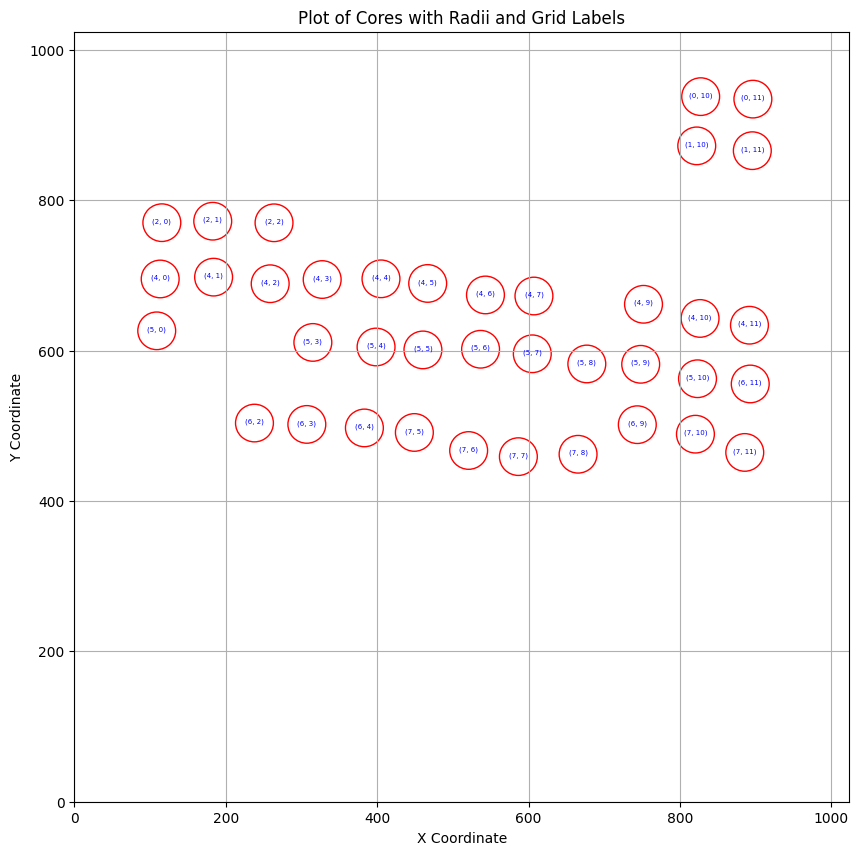

In [4]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)

# Plot each core with its radius and label
for idx, core in enumerate(data):
    # Draw the core as a circle
    circle = plt.Circle((core['x'], core['y']), radius=core['radius'], edgecolor='r', facecolor='none')
    ax.add_patch(circle)

    # Get grid position for the label
    grid_label = None
    for pos, indices in grid_positions.items():
        if idx in indices:
            grid_label = pos
            break
    
    # Only label the core if we found a grid position
    if grid_label is not None:
        ax.text(core['x'], core['y'], str(grid_label), color='blue', fontsize=5, ha='center')

# Set the limits of the plot to the size of the image
ax.set_xlim([0, 1024])
ax.set_ylim([0, 1024])

# Add grid, legend, and labels
ax.grid(True)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_title('Plot of Cores with Radii and Grid Labels')

# Show the plot
plt.show()

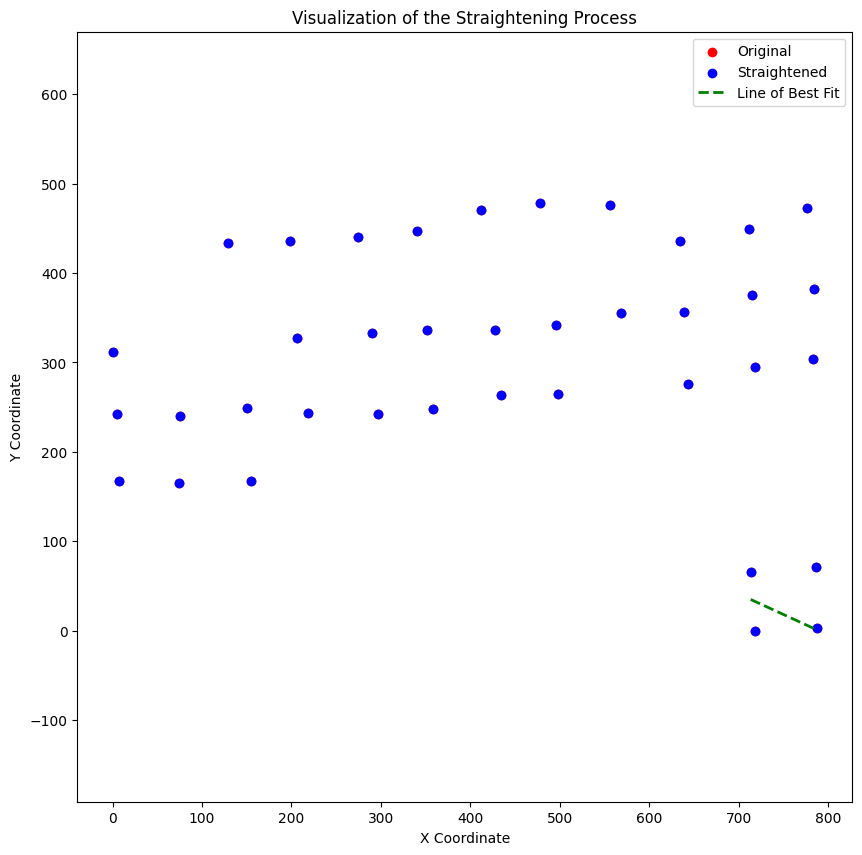

In [5]:
model, min_x, max_x = calculate_line_of_best_fit(normalized_coordinates, grid_spacing, bottom_rows_count)

# Visualize the straightening process
visualize_straightening(normalized_coordinates, straightened_coordinates, model, min_x, max_x)